# Figure 12: Predicted SM vs SFR Comparison

This notebook recreates the multipanel SM vs SFR simulation figures from notebook 01, but using predicted values instead of true values.

**Two figures are generated:**
1. **UMAP-kNN Predicted SM vs SFR** - Using spatial neighborhood predictions
2. **Autoencoder Predicted SM vs SFR** - Using neural network predictions

**Each figure shows:**
- Individual simulation panels + combined panel (using draw_grid_A layout)
- Linear SM and SFR values on log-log axes
- Mass cut reference lines at 1e9 and 1e10 M☉
- Predictions generated using cross-validation to avoid overfitting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import sys
import pickle
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold

# Add src to path
sys.path.append('../src')

from utils.analysis import sim_name, colors, times
from utils.data_processing import load_autoencoder_data
from utils.plotting import draw_grid_A

# Define axis labels (matching notebook 01)
SM_axis_label = r'$M_*$ [$M_{\odot}$]'
SFR_axis_label = r'${\rm SFR}$ [$M_{\odot}$/yr]'

# LaTeX font setup
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

%matplotlib inline

## Load Data

In [2]:
# Load processed simulation data
with open('../data/sim_data_processed.pkl', 'rb') as f:
    sim_data = pickle.load(f)

# Load UMAP embeddings
combined_labels = np.load('../data/combined_labels.npy')
embedding = np.load('../data/umap_embedding.npy')

# Reconstruct UMAP embeddings by simulation
for i, sim in enumerate(sim_name):
    if sim_data[sim] is not None:
        sim_mask = combined_labels == i
        sim_data[sim]['umap'] = embedding[sim_mask]

print("Loaded UMAP data by simulation:")
for sim in sim_name:
    if sim_data[sim] is not None:
        print(f"{sim:>15s}: {sim_data[sim]['umap'].shape[0]:>8,d} galaxies")

Loaded UMAP data by simulation:
          EAGLE:    7,445 galaxies
      Illustris:   19,354 galaxies
   IllustrisTNG:   12,220 galaxies
         Mufasa:    1,900 galaxies
          Simba:    1,982 galaxies
         SC-SAM:   12,821 galaxies
UniverseMachine:    7,361 galaxies


In [3]:
# Load autoencoder predictions
ae_data = load_autoencoder_data(sim_data)

print("Loaded autoencoder data.")

Loaded predictions_sfh.npy: shape (63083, 139)
Loaded predictions_sfh_w.npy: shape (63083, 139)
Loaded predictions_sfr.npy: shape (63083, 2)
Loaded predictions_sfr_w.npy: shape (63083, 2)
Loaded predictions_sim.npy: shape (63083, 7)
Loaded predictions_sim_w.npy: shape (63083, 7)
Reordering predictions from sim_name_z to sim_name order...
Reordered predictions_sfh: shape (63083, 139)
Reordered predictions_sfh_w: shape (63083, 139)
Reordered predictions_sfr: shape (63083, 2)
Reordered predictions_sfr_w: shape (63083, 2)
Reordered predictions_sim: shape (63083, 7), columns reordered to sim_name
Reordered predictions_sim_w: shape (63083, 7), columns reordered to sim_name
Split EAGLE: 7445 galaxies
Split Illustris: 19354 galaxies
Split IllustrisTNG: 12220 galaxies
Split Mufasa: 1900 galaxies
Split Simba: 1982 galaxies
Split SC-SAM: 12821 galaxies
Split UniverseMachine: 7361 galaxies
Loaded autoencoder data.


## Extract True Values for kNN Training

In [4]:
# Combine true values from all simulations (z=0)
true_sm = []
true_sfr = []

for i, sim in enumerate(sim_name):
    if sim_data[sim] is not None:
        sim_mask = combined_labels == i
        # Get z=0 values
        true_sm.extend(sim_data[sim]['sm'])  
        true_sfr.extend(sim_data[sim]['sfh_raw'][:, -1])

# Convert to log space for training
true_logsm = np.log10(np.array(true_sm))
true_logsfr = np.log10(np.array(true_sfr) + 1e-3)  # Avoid log(0)

print(f"Extracted true values for {len(true_sm):,} galaxies")
print(f"logSM range: {np.min(true_logsm):.2f} to {np.max(true_logsm):.2f} [log(M☉)]")
print(f"logSFR range: {np.min(true_logsfr):.2f} to {np.max(true_logsfr):.2f} [log(M☉/yr)]")

Extracted true values for 63,083 galaxies
logSM range: 9.00 to 12.57 [log(M☉)]
logSFR range: -3.00 to 1.90 [log(M☉/yr)]


## Generate Cross-Validated Predictions

In [5]:
# Cross-validation prediction function (from notebook 11)
def knn_cv_predict(knn, X, y, cv_type='kfold', n_splits=5):
    """Generate cross-validated predictions to avoid overfitting."""
    if cv_type == 'kfold':
        cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    else:
        raise ValueError("cv_type must be 'kfold'")

    preds = np.zeros(len(y))
    for train_idx, test_idx in cv.split(X):
        knn.fit(X[train_idx], y[train_idx])
        preds[test_idx] = knn.predict(X[test_idx])
    return preds

print("Cross-validation prediction function defined.")

Cross-validation prediction function defined.


In [6]:
# Use optimal k values from notebook 11
optimal_k_sm = 500
optimal_k_sfr = 500

print(f"Generating UMAP-kNN predictions with cross-validation...")
print(f"SM: k = {optimal_k_sm}")
print(f"SFR: k = {optimal_k_sfr}")

# Create kNN models
knn_sm = KNeighborsRegressor(n_neighbors=optimal_k_sm, weights='distance')
knn_sfr = KNeighborsRegressor(n_neighbors=optimal_k_sfr, weights='distance')

# Generate cross-validated predictions in log space
pred_logsm_umap = knn_cv_predict(knn_sm, embedding, true_logsm, cv_type='kfold', n_splits=5)
pred_logsfr_umap = knn_cv_predict(knn_sfr, embedding, true_logsfr, cv_type='kfold', n_splits=5)

print("UMAP-kNN cross-validated predictions generated.")

Generating UMAP-kNN predictions with cross-validation...
SM: k = 500
SFR: k = 500
UMAP-kNN cross-validated predictions generated.


In [7]:
# Extract autoencoder predictions (already in log space)
print("Extracting autoencoder predictions...")

pred_logsm_ae = ae_data['predictions_sfr'][:, 0]  # log(SM)
pred_logsfr_ae = ae_data['predictions_sfr'][:, 1]  # log(SFR)

print("Autoencoder predictions extracted.")

Extracting autoencoder predictions...
Autoencoder predictions extracted.


## Convert Predictions to Linear Space

In [8]:
# Convert log predictions to linear values for plotting
print("Converting predictions to linear space...")

# UMAP-kNN predictions
pred_sm_umap = 10**pred_logsm_umap  # M☉
pred_sfr_umap = 10**pred_logsfr_umap  # M☉/yr

# Autoencoder predictions  
pred_sm_ae = 10**pred_logsm_ae  # M☉
pred_sfr_ae = 10**pred_logsfr_ae  # M☉/yr

print(f"UMAP-kNN SM range: {np.min(pred_sm_umap):.2e} to {np.max(pred_sm_umap):.2e} M☉")
print(f"UMAP-kNN SFR range: {np.min(pred_sfr_umap):.2e} to {np.max(pred_sfr_umap):.2e} M☉/yr")
print(f"Autoencoder SM range: {np.min(pred_sm_ae):.2e} to {np.max(pred_sm_ae):.2e} M☉")
print(f"Autoencoder SFR range: {np.min(pred_sfr_ae):.2e} to {np.max(pred_sfr_ae):.2e} M☉/yr")

Converting predictions to linear space...
UMAP-kNN SM range: 1.18e+09 to 1.72e+11 M☉
UMAP-kNN SFR range: 2.10e-03 to 3.83e+00 M☉/yr
Autoencoder SM range: 1.22e+09 to 1.02e+12 M☉
Autoencoder SFR range: 5.15e-01 to 3.57e+03 M☉/yr


## Create Figure Generation Function

In [12]:
def create_predicted_figure(pred_sm, pred_sfr, method_name):
    """
    Create multipanel SM vs SFR figure using predicted values with draw_grid_A layout.
    
    Parameters
    ----------
    pred_sm : array_like
        Predicted stellar masses in M☉ (linear values)
    pred_sfr : array_like  
        Predicted star formation rates in M☉/yr (linear values)
    method_name : str
        Name of prediction method for title
        
    Returns
    -------
    fig : matplotlib.figure.Figure
        Generated figure
    """
    # Calculate plot limits
    minsm  = np.min([np.min(sim_data[sim]['sm']) for sim in sim_name[:-1] if sim_data[sim] is not None])  # exclude UM
    maxsm  = np.max([np.max(sim_data[sim]['sm']) for sim in sim_name if sim_data[sim] is not None])
    minsfr = np.min([np.min(sim_data[sim]['sfh_raw'].T[-1][sim_data[sim]['sfh_raw'].T[-1] > 0.]) 
                    for sim in sim_name[:-2] if sim_data[sim] is not None])  # ignore 0s, UM, SC
    maxsfr = np.max([np.max(sim_data[sim]['sfh_raw'].T[-1]) for sim in sim_name if sim_data[sim] is not None])

    print(f"Plot limits: SM [{minsm:.1e}, {maxsm:.1e}], SFR [{minsfr:.1e}, {maxsfr:.1e}]")

    # Create the multi-panel figure
    ax = draw_grid_A(xlabel=SM_axis_label, ylabel=SFR_axis_label, 
                    xlim=[minsm, maxsm], ylim=[minsfr, maxsfr])
    
    # Plot each simulation
    for i, sim in enumerate(sim_name):
        if sim_data[sim] is None:
            continue
            
        # Get simulation mask
        sim_mask = combined_labels == i
        
        # Plot in individual panel
        c = colors[sim]
        ax[sim].loglog(pred_sm[sim_mask], pred_sfr[sim_mask], '.', c=c, ms=1)
        
        # Add mass cut reference lines
        ax[sim].axvline(1e9, c='gray', linestyle=':', alpha=0.5)
        ax[sim].axvline(1e10, c='gray', linestyle='--', alpha=0.5)
        
        # Add simulation name label
        ax[sim].text(10**8.2, 10**1.5, sim, fontsize=16, 
                    bbox=dict(facecolor='white', edgecolor='white', linewidth=0))
        
        # Custom ticks (matching notebook 01)
        ax[sim].set_xticks([1e8,1e9,1e10,1e11,1e12], labels=["","$10^9$","","$10^{11}$",""])
        ax[sim].set_xticks([7e7,8e7,9e7,
                            2e8,3e8,4e8,5e8,6e8,7e8,9e8,
                            2e9,3e9,4e9,5e9,6e9,7e9,9e9,
                            2e10,3e10,4e10,5e10,6e10,7e10,9e10,
                            2e11,3e11,4e11,5e11,6e11,7e11,9e11,
                            2e12,3e12,4e12], minor=True)
        
        # Plot in combined panel
        ax['large'].loglog(pred_sm[sim_mask], pred_sfr[sim_mask], '.', c=c, ms=3, alpha=0.2)
    
    # Add mass cut lines to combined panel
    ax['large'].axvline(1e9, c='r')
    ax['large'].axvline(1e10, c='r')
    ax['large'].text(10**8, 10**1.68, f'{method_name} Predictions', fontsize=16, 
                    bbox=dict(facecolor='white', edgecolor='white', linewidth=0))
    
    return plt.gcf()

print("Figure generation function defined.")

Figure generation function defined.


## Generate Figure 1: UMAP-kNN Predictions

Generating UMAP-kNN prediction figure...
Plot limits: SM [1.0e+09, 3.7e+12], SFR [7.1e-03, 7.9e+01]


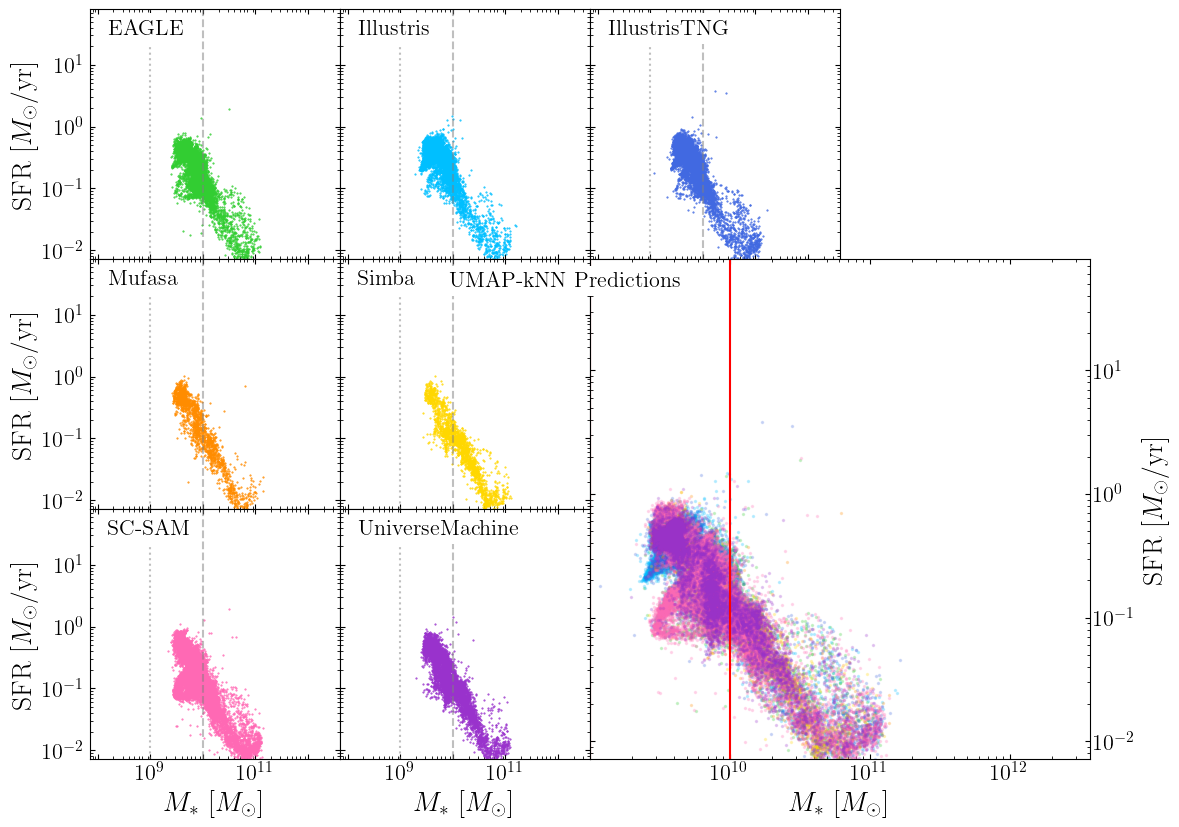

UMAP-kNN prediction figure generated and saved!


In [13]:
# Create UMAP-kNN prediction figure
print("Generating UMAP-kNN prediction figure...")

fig1 = create_predicted_figure(pred_sm_umap, pred_sfr_umap, 'UMAP-kNN')

# Save figure
plt.savefig('../figures/predicted_sm_sfr_umap.png', dpi=300, bbox_inches='tight')
plt.savefig('../figures/predicted_sm_sfr_umap.pdf', bbox_inches='tight')

plt.show()
print("UMAP-kNN prediction figure generated and saved!")

## Generate Figure 2: Autoencoder Predictions

Generating autoencoder prediction figure...
Plot limits: SM [1.0e+09, 3.7e+12], SFR [7.1e-03, 7.9e+01]


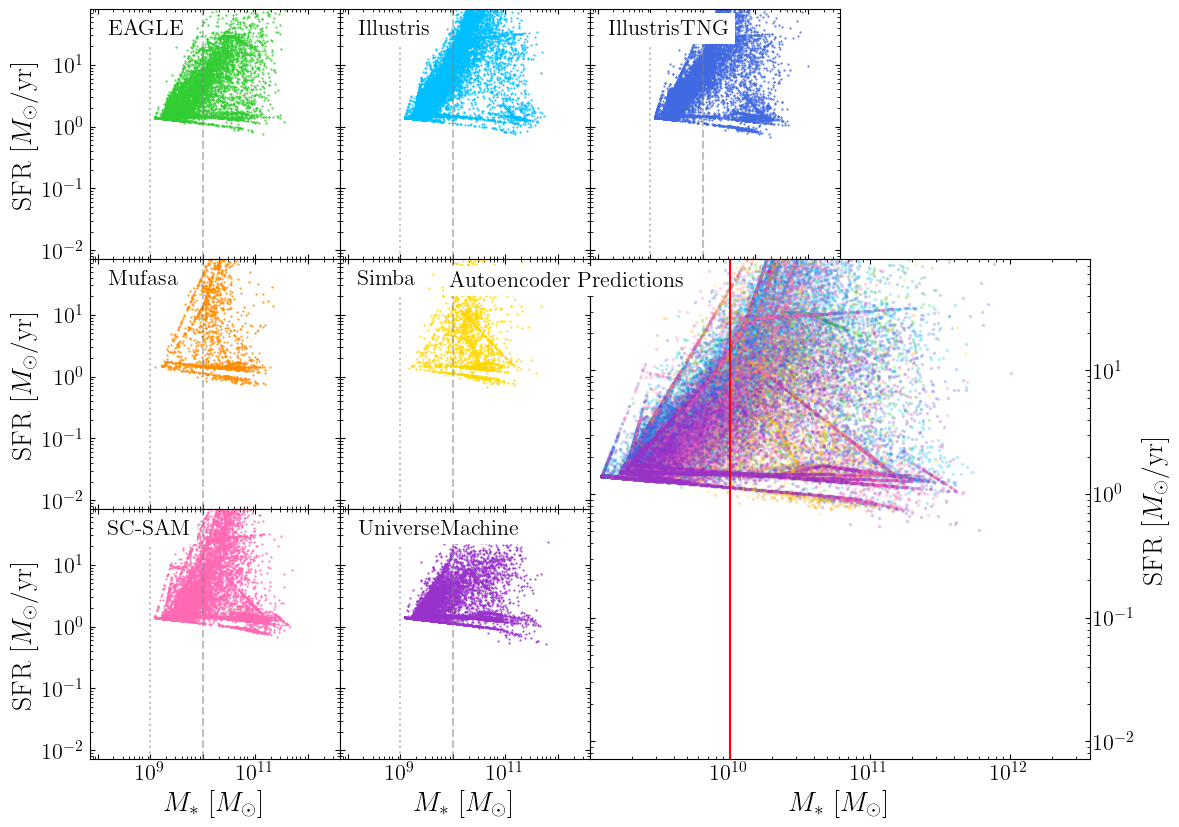

Autoencoder prediction figure generated and saved!


In [14]:
# Create autoencoder prediction figure
print("Generating autoencoder prediction figure...")

fig2 = create_predicted_figure(pred_sm_ae, pred_sfr_ae, 'Autoencoder')

# Save figure
plt.savefig('../figures/predicted_sm_sfr_autoencoder.png', dpi=300, bbox_inches='tight')
plt.savefig('../figures/predicted_sm_sfr_autoencoder.pdf', bbox_inches='tight')

plt.show()
print("Autoencoder prediction figure generated and saved!")